## Image Augmentation for Shihao
***Jan 03, 2022***

You can take a look at these papers:
- Yoo, Jaejun, Namhyuk Ahn, and Kyung-Ah Sohn. "Rethinking data augmentation for image super-resolution: A comprehensive analysis and a new strategy." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2020.
- Feng, Ruicheng, et al. "Suppressing model overfitting for image super-resolution networks." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops. 2019.
- Shorten, Connor, and Taghi M. Khoshgoftaar. "A survey on image data augmentation for deep learning." Journal of Big Data 6.1 (2019): 1-48.

You can try to reproduce some of the augmentations:
- Rotation, Translation
- Blending of T1w and T2w
- and the more advanced techniques (CutOut, CutMix etc) presented in the papers if you have time and interest in pushing the limit

The MRI data is 3D and in grayscale. Preferably you would conduct the augmentations in 3D space instead of just 2D augmentations like the natural images presented in papers above.
***

## Weighted Patch Sampling
***Jan 18, 2022***

To implement weighted patch sampling for low-resolution (LR) and high-resolution (HR) image pair. 
Currently the implemented sampling method randomly extract pair patches from the whole volume, but the human brain is mostly contained 
in the centre of the acquired volume. This may result in bad patches that not including brain when inputted for training, leading to 
training instability and worse model performance:
- Should be implemented purely in PyTorch/NumPy
- Please evaluate the time to run the patch sampling function on CPU, use proper timing function
- You should optimize the code; 3D image pre-processing can be a bottleneck in the training process
- The patch size is arbitrary, same or smaller than the image
- The user may want N samples out of the same volume, usually is square in the axial view, but any value in the slice direction

In [1]:
'''
updated on 16:33 Saturday, Jan 22, 2022, by Zeng Shihao
completed first draft of class WeightedPatchSampling
benchmarked sampler function

updated on 23:52 Thursday, Jan 20, 2022, by Zeng Shihao
completed initial structure
drafted getsample assuming rectangle sampling area

updated on 19:02 Monday, Jan 10, 2022, by Zeng Shihao
modified aug_randomcutmix3d() in class Vol2PatchDataTransform_Custom:
    move cutmix location generation out
    replaced loops with [a1:a2, ...]
modified __call__() in class Vol2PatchDataTransform_Custom:
    replaced random.randint with torch.randint()
    added cutmix/cutout location and size distribution option
    data&target cutmix/cutout correspondance

updated on 11:50 Monday, Jan 10, 2022, by Zeng Shihao
added aug_transform(), aug_randomcutmix3d() in class Vol2PatchDataTransform_Custom
modified visualise_img(): delete rot90()
added visualise_sideview(), blender()
'''

'\nupdated on 16:33 Saturday, Jan 22, 2022, by Zeng Shihao\ncompleted first draft of class WeightedPatchSampling\nbenchmarked sampler function\n\nupdated on 23:52 Thursday, Jan 20, 2022, by Zeng Shihao\ncompleted initial structure\ndrafted getsample assuming rectangle sampling area\n\nupdated on 19:02 Monday, Jan 10, 2022, by Zeng Shihao\nmodified aug_randomcutmix3d() in class Vol2PatchDataTransform_Custom:\n    move cutmix location generation out\n    replaced loops with [a1:a2, ...]\nmodified __call__() in class Vol2PatchDataTransform_Custom:\n    replaced random.randint with torch.randint()\n    added cutmix/cutout location and size distribution option\n    data&target cutmix/cutout correspondance\n\nupdated on 11:50 Monday, Jan 10, 2022, by Zeng Shihao\nadded aug_transform(), aug_randomcutmix3d() in class Vol2PatchDataTransform_Custom\nmodified visualise_img(): delete rot90()\nadded visualise_sideview(), blender()\n'

In [2]:
import os
import math

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import scipy, scipy.io
import h5py
import skimage.transform, skimage.io
import monai

import torch
import torchvision.transforms as T
from torch.nn import functional as F
import torch.utils.benchmark as benchmark

import maths

No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.4'


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
## This is the function you can work with

class Vol2PatchDataTransform_Custom(object):
    """
    Apply random Rician noise to volume samples, normalise the data and convert
    them to Tensors.
    Image Augmentation Applied, involving 
    rotation, translation, (in 3D?)
    Blending of T1w and T2w,
    Cutout
    CutMix
    
    Args:
        norm (str)
    Returns:
        torch.Tensor: data
        torch.Tensor: target
    """
    def __init__(self, noise_std: float=0.1, norm='minmax', aug: bool = False):
        self.noise = monai.transforms.RandRicianNoise(prob=1.0, std=noise_std, relative=True, channel_wise=True, sample_std=False)
        self.norm = norm
        self.aug = aug
    
    def aug_transform(self, img, degree, H, V, padding='zeros'):
        '''
        img: tensor image
        degree: counter-clockwise in int:degree, 
        H: Horizontal translation in float:(-1, 1[left]), 
        V: Vertical translation in float:(-1, 1[up])
        padding: 'zeros' 'border' 'reflection'
        '''
        angle = degree*math.pi/180
        theta = torch.tensor([
        [math.cos(angle),math.sin(-angle),H],
        [math.sin(angle),math.cos(angle) ,V]
        ], dtype=torch.float) # transform matrix

        C, A, W, H = img.size()
        size = torch.Size((1, A, W, H))

        grid = F.affine_grid(theta.unsqueeze(0), size)
        if img.dtype == torch.float64:
            grid = grid.double()
        output = F.grid_sample(img[0].unsqueeze(0), grid, padding_mode=padding)
        return output[0]
    
    def aug_randomcutmix3d(self, img, img_mix, Acenter, Hcenter, Wcenter, axialsize, planarsize, cutout = False):
        A_, H_, W_ = img.size()
        a1 = max(Acenter-axialsize//2, 0)
        a2 = min(Acenter+axialsize//2, A_)
        h1 = max(Hcenter-planarsize//2, 0)
        h2 = min(Hcenter+planarsize//2, H_)
        w1 = max(Wcenter-planarsize//2, 0)
        w2 = min(Wcenter+planarsize//2, W_)
        if cutout:
            img[a1:a2, h1:h2, w1:w2] = 0
        else:
            img[a1:a2, h1:h2, w1:w2] = img_mix[a1:a2, h1:h2, w1:w2]
        return img
    
    
    def __call__(self, data, target, noise_seed, cutout = False, cutmix = False, cutmixdata = None, cutmixtarget = None):
        
        data = torch.from_numpy(data)
        target = torch.from_numpy(target)

        target = target.unsqueeze(0)
        data_input = torch.stack((data, data))
        self.noise.set_random_state(noise_seed)
        data_input = self.noise(data_input)

        if self.norm == 'zscore':
            data_input, mean, std = maths.zscore_norm_t(data_input, 1e-11)
            target, _, _ = maths.zscore_norm_t(target, 1e-11)
            
            data_input = data_input.clamp(-2, 6)
            target = target.clamp(-2, 6)
        elif self.norm == 'minmax':
            data_input = maths.minmax_norm_t(data_input)
            target = maths.minmax_norm_t(target)
            
        # the same for possible cutmix image input
        if cutmix:
            cutmixdata = torch.from_numpy(cutmixdata)
            cutmixtarget = torch.from_numpy(cutmixtarget)
            cutmixtarget = cutmixtarget.unsqueeze(0)
            cutmixdata = torch.stack((cutmixdata, cutmixdata))
            self.noise.set_random_state(noise_seed)
            data_input = self.noise(data_input)
            if self.norm == 'zscore':
                cutmixdata, mean, std = maths.zscore_norm_t(cutmixdata, 1e-11)
                cutmixtarget, _, _ = maths.zscore_norm_t(cutmixtarget, 1e-11)
                cutmixdata = cutmixdata.clamp(-2, 6)
                cutmixtarget = cutmixtarget.clamp(-2, 6)
            elif self.norm == 'minmax':
                cutmixdata = maths.minmax_norm_t(cutmixdata)
                cutmixtarget = maths.minmax_norm_t(cutmixtarget)
                
        # Augmentation        
        if self.aug:
            #print(data_input.shape) # e.g. [2, 128, 128, 32]
            #print(target.shape) # e.g. [1, 256, 256, 64]
            data_input = data_input.permute(0,3,1,2) # (C, A, H, W), e.g. [2, 32, 128, 128]
            target = target.permute(0,3,1,2) # (C, A, H, W), e.g. [1, 64, 256, 256]
            
            data_input = self.aug_transform(data_input, 90, 0, 0) # degree, H, V
            target = self.aug_transform(target, 90, 0, 0)
            #print(data_input.shape) # (A, H, W), e.g. [32, 128, 128]
            #print(target.shape) # (A, H, W), e.g. [64, 256, 256]
            
            #cutmix/cutout location generation
            A, H, W = data_input.size()
            Acenter = torch.randint(0, A-1, (1,))
            Hcenter = torch.randint(0, H-1, (1,))
            Wcenter = torch.randint(0, W-1, (1,))
            axialsize = torch.randint(A//10, A//2, (1,))
            planarsize = torch.randint(H//10, H//2, (1,))

            if cutout:
                data_input = self.aug_randomcutmix3d(data_input, cutmixdata, Acenter, Hcenter, Wcenter, axialsize, planarsize, cutout = True)
                target = self.aug_randomcutmix3d(target, cutmixtarget, Acenter*2, Hcenter*2, Wcenter*2, axialsize*2, planarsize*2, cutout = True)
                
            if cutmix:
                cutmixdata = cutmixdata.permute(0,3,1,2)
                cutmixtarget = cutmixtarget.permute(0,3,1,2)

                cutmixdata = self.aug_transform(cutmixdata, 90, 0, 0)
                cutmixtarget = self.aug_transform(cutmixtarget, 90, 0, 0)
                

                #self, img, img_mix, Acenter, Hcenter, Wcenter, axialsize, planarsize, cutout = False
                data_input = self.aug_randomcutmix3d(data_input, cutmixdata, Acenter, Hcenter, Wcenter, axialsize, planarsize)
                target = self.aug_randomcutmix3d(target, cutmixtarget, Acenter*2, Hcenter*2, Wcenter*2, axialsize*2, planarsize*2)
            data_input = data_input.permute(1,2,0) # (H, W, A), e.g. [128, 128, 32]
            target = target.permute(1,2,0)
            
        return data_input.float(), target.float()
    

In [5]:
class WeightedPatchSampling(object):
    '''
    
    '''
    def __init__(self):
        pass

    def getheadrange(self, data, threshold):
        # data: tensor(H, W, A), e.g. (128, 128, 32)
        H, W, A = data.size()

        # gaussian, three 1d kernel
        
        # find from midpoint to center
        Hmidline = data[:, W//2, A//2]
        i = 0
        while Hmidline[i]<threshold:
            i+=1
        H1 = i
        # H1_1 = next(i for i, x in enumerate(Hmidline) if x >= value)
        j = H-1
        while Hmidline[j]<threshold:
            j-=1
        H2 = j
        Wmidline = data[H//2, :, A//2]
        i = 0
        while Wmidline[i]<threshold:
            i+=1
        W1 = i
        j = W-1
        while Wmidline[j]<threshold:
            j-=1
        W2 = j
        Amidline = data[H//2, W//2, :]
        i = A//3
        while Amidline[i]<threshold:
            i+=1
        A1 = i
        j = A-1
        while Amidline[j]<threshold:
            j-=1
        A2 = j
        headrange = (H1, H2, W1, W2, A1, A2)
        return headrange # (H1, H2, W1, W2, A1, A2)
    
    def monitorheadrange(self, datainput, targetinput, headrange):
        # data: tensor(H, W, A), e.g. (128, 128, 32)
        data = datainput.clone()
        H1, H2, W1, W2, A1, A2 = headrange
        data[H1:H2, W1:W2, A1] = 1
        data[H1:H2, W1:W2, A2] = 1
        data[H1:H2, W1, A1:A2] = 1
        data[H1:H2, W2, A1:A2] = 1
        data[H1, W1:W2, A1:A2] = 1
        data[H2, W1:W2, A1:A2] = 1
        return data
        


    def getsample(self, data, target, Nsample, headrange, minPsize, minAsize):
        sample = []
        smallorigin = torch.stack((torch.randint(headrange[0], headrange[1]-minPsize, (Nsample,)), torch.randint(headrange[2], headrange[3]-minPsize, (Nsample,))))
        # smallorigin[[heights], [widths]]
        for i in range(Nsample):

            origin = torch.tensor([smallorigin[0, i], smallorigin[1, i]]) # tensor[x1][x2] or tensor[x1, x2] ?
            psize = torch.randint(minPsize, min(headrange[1]-origin[0], headrange[3]-origin[1]), (1,)).item() # torch.randint()[] ?
            h_1 = origin[0]
            h_2 = origin[0]+psize
            w_1 = origin[1]
            w_2 = origin[1]+psize
            a_1 = torch.randint(headrange[4], headrange[5]-minAsize, (1,)).item()
            a_2 = torch.randint(a_1+minAsize, headrange[5], (1,))[0].item()
            datasample = data[h_1:h_2, w_1:w_2, a_1:a_2]
            targetsample = target[2*h_1:2*h_2, 2*w_1:2*w_2, 2*a_1:2*a_2]
            sample.append([datasample, targetsample])
        return sample # list(Nsample, 2, tensor(H, W, A))

    def __call__(self, data, target, monitor = False, Nsample = 1, minplanarsize = 10, minaxialsize = 3, grayscalethreshold = 0.3):
        # data: tensor(H, W, A), e.g. (128, 128, 32), same for target (256, 256, 64)

        headrange = self.getheadrange(data, grayscalethreshold) # (H1, H2, W1, W2, A1, A2)
        if headrange[5]-headrange[4] < minaxialsize or min(headrange[1]-headrange[0], headrange[3]-headrange[2]) < minplanarsize:
            raise ValueError('Recognized object size smaller than minimum.')

        if monitor:
            monitor_data = self.monitorheadrange(data, target, headrange)
            return monitor_data


        sample = self.getsample(data, target, Nsample, headrange, minplanarsize, minaxialsize)

        return sample # list(Nsample, 2), element: (H, W, A)


In [6]:
def visualise_img(image, fig_size=(4, 8), res=200):
    fig = plt.figure(dpi=res)
    grid = ImageGrid(fig, 111, nrows_ncols=fig_size, axes_pad=0.0)
    for i in range(image.shape[-1]):
        #grid[i].imshow(np.rot90(image[i, ...], 1), cmap='gray') # if rot90 here, the translatory transform direction changed
        grid[i].imshow(image[..., i], cmap='gray')
        grid[i].axis('off')
        grid[i].set_xticks([])
        grid[i].set_yticks([])
    plt.show()

In [7]:
def visualise_sideview(image, grid_num, fig_size, res=200):
    
    if grid_num != fig_size[0]*fig_size[1]:
        raise ValueError('grids number and axial resolution does not match')
    
    image = F.interpolate(image, size=grid_num, mode='linear') # interpolate to a cubic e.g. from [32, 128, 128] to [128, 128, 128]
    print(image.size())
    
    fig = plt.figure(dpi=res)
    grid = ImageGrid(fig, 111, nrows_ncols=fig_size, axes_pad=0.0)
    for i in range(grid_num):
        #grid[i].imshow(np.rot90(image[i, ...], 1), cmap='gray')
        grid[i].imshow(image[i, ...], cmap='gray')
        grid[i].axis('off')
        grid[i].set_xticks([])
        grid[i].set_yticks([])
    plt.show()

In [8]:
def blender(img1, img2, w1):
    if w1 > 1 or w1 < 0:
        raise ValueError('0<=w1<=1 not satisfied.')
        return
    if img1.size != img2.size:
        raise ValueError('The two inputs must have same size.')
        
    return w1*img1+(1-w1)*img2

## Test your code here

### load data

In [9]:
# data file name
fname = '101915_3T_T2w_SPC1'
fnamemix = '105216_3T_T2w_SPC2'
# Load data
with h5py.File(os.path.join('data', fname+'.h5')) as f:
    x = f['data'][()]
    y = f['target'][()]
with h5py.File(os.path.join('data', fnamemix+'.h5')) as fmix:
    x_mix = fmix['data'][()]
    y_mix = fmix['target'][()]
print('Shape of x (input, Low Res) =', x.shape)
print('Shape of y (target, High Res) =', y.shape)
print('Shape of x_mix (input, Low Res) =', x_mix.shape)
print('Shape of y_mix (target, High Res) =', y_mix.shape)

Shape of x (input, Low Res) = (128, 128, 32)
Shape of y (target, High Res) = (256, 256, 64)
Shape of x_mix (input, Low Res) = (128, 128, 32)
Shape of y_mix (target, High Res) = (256, 256, 64)


### perform augmentation

In [10]:
transform = Vol2PatchDataTransform_Custom(noise_std=0.1, aug=True)
#data, target, noise_seed, cutout = False, cutmix = False, cutmixdata = None, cutmixtarget = None
x_t, y_t = transform(x, y, 0, cutmix = True, cutmixdata=x_mix, cutmixtarget=y_mix)
print('Shape of augmented x (input, Low Res) =', x_t.shape)
print('Shape of augmented y (input, Low Res) =', y_t.shape)

Shape of augmented x (input, Low Res) = torch.Size([128, 128, 32])
Shape of augmented y (input, Low Res) = torch.Size([256, 256, 64])


### visualize augmentation result

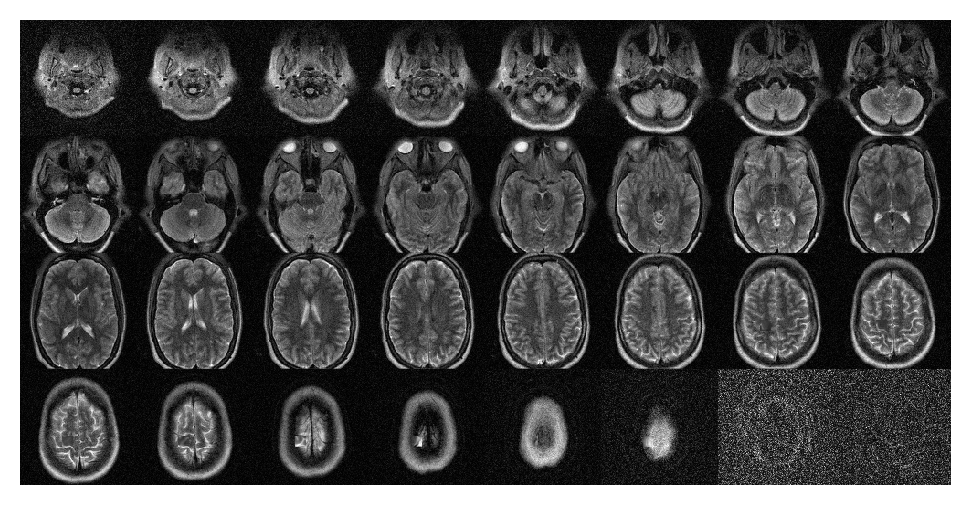

In [11]:
visualise_img(x_t, (4, 8))
#visualise_img(y_t, (8, 8), res=1000)

In [12]:
#visualise_sideview(x_t, 128, (16, 8), res = 600)

### perform weighted sampling

In [13]:
sampler = WeightedPatchSampling()
nsample = 20
sample = sampler(x_t, y_t, Nsample = nsample, minplanarsize=30, minaxialsize=8)

### visualize samples

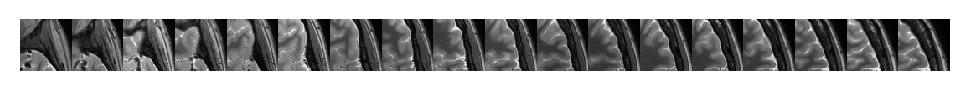

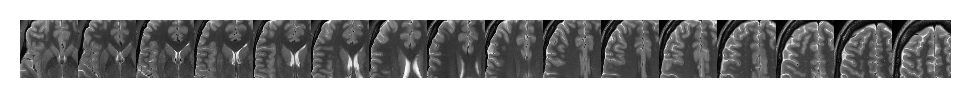

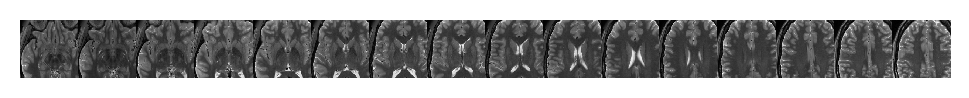

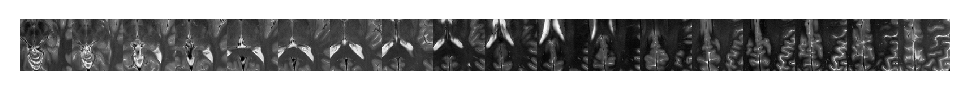

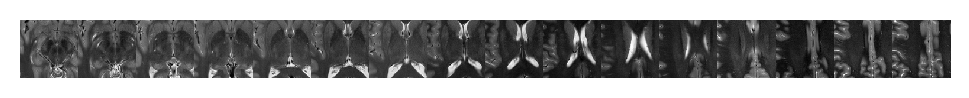

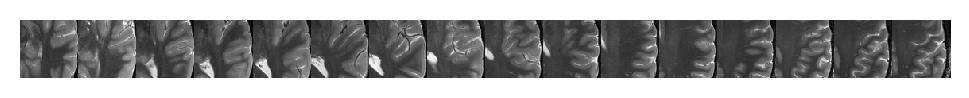

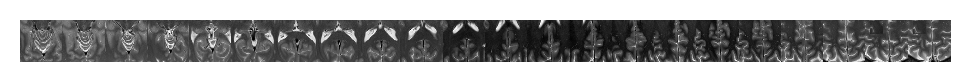

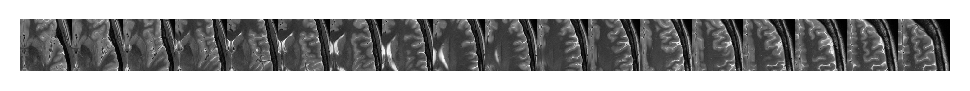

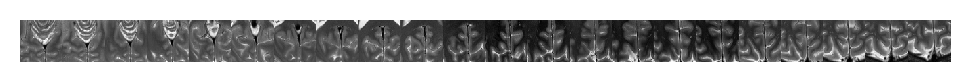

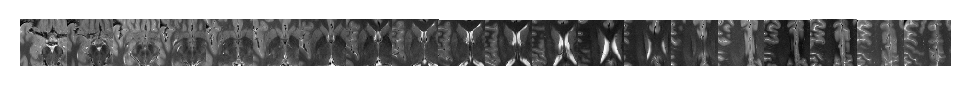

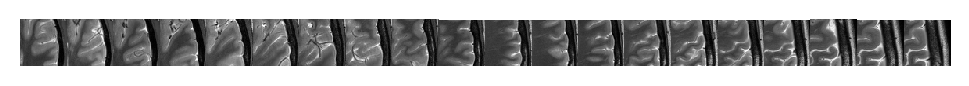

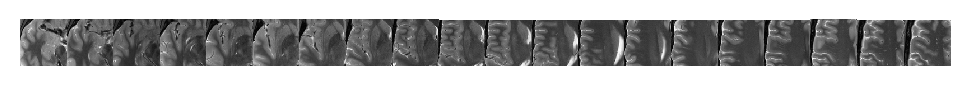

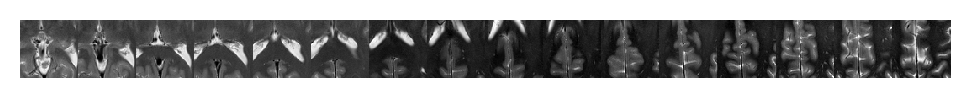

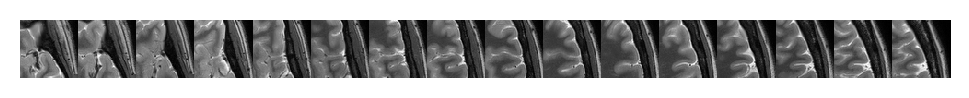

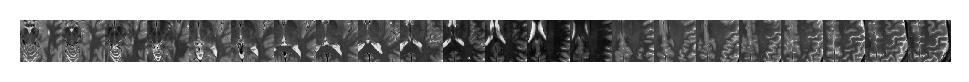

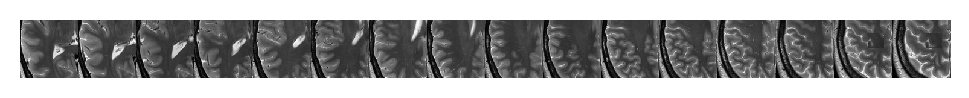

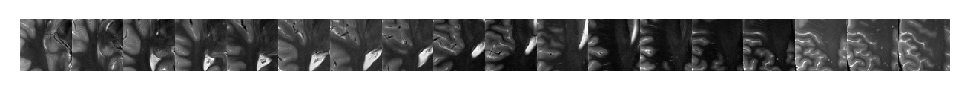

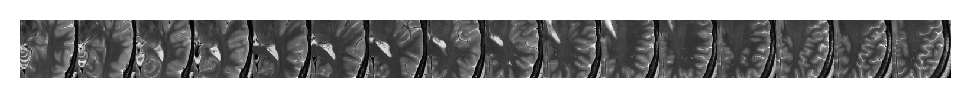

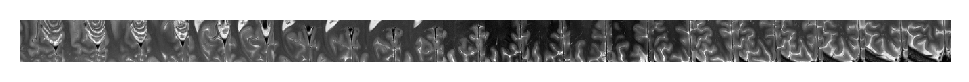

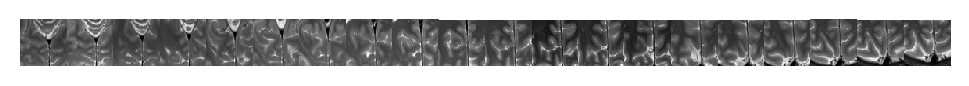

In [14]:
for i in range(nsample):
    A = sample[i][1].size()
    img = sample[i][1]
    visualise_img(img, (1, A[2]))

### examine sampling area

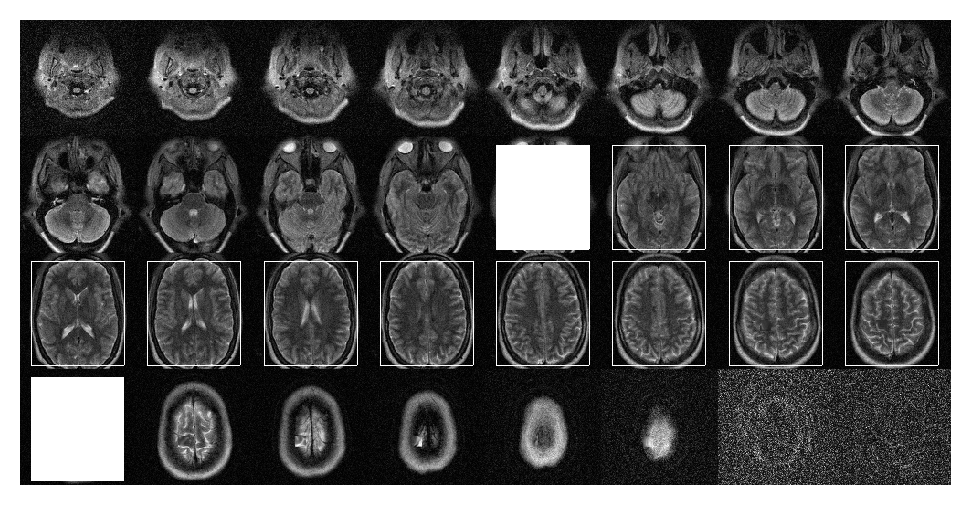

In [15]:
monitor_data = sampler(x_t, y_t, monitor=True, grayscalethreshold=0.3)
visualise_img(monitor_data, (4, 8))

### benchmarking

In [16]:
t_WeightedPatchSampling = benchmark.Timer(
    stmt='sample = sampler(x_t, y_t, Nsample = nsample, minplanarsize=30, minaxialsize=8)',
    setup='from __main__ import sampler',
    globals={'x_t': x_t, 'y_t':y_t, 'nsample':nsample})
print(t_WeightedPatchSampling.timeit(100)) # get 20 sample from 100 run average

t_Vol2PatchDataTransform_Custom = benchmark.Timer(
    stmt='x_t, y_t = transform(x, y, 0, cutmix = True, cutmixdata=x_mix, cutmixtarget=y_mix)',
    setup='from __main__ import transform',
    globals={'x': x, 'y':y, 'x_mix': x_mix, 'y_mix': y_mix})
print(t_Vol2PatchDataTransform_Custom.timeit(10)) # perform 1 tranformation(augmentation) from 10 run average

sample = sampler(x_t, y_t, Nsample = nsample, minplanarsize=30, minaxialsize=8)
setup: from __main__ import sampler
  2.50 ms
  1 measurement, 100 runs , 1 thread
x_t, y_t = transform(x, y, 0, cutmix = True, cutmixdata=x_mix, cutmixtarget=y_mix)
setup: from __main__ import transform
  413.59 ms
  1 measurement, 10 runs , 1 thread
